In [15]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [1]:
import os
os.chdir('T:/Projects/LSTM-forecast/src')
import featureEng as fe
import processStocks as ps
import lstm
import getStocks
import visualize
import predicts

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10330150693132808378
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6814913823
locality {
  bus_id: 1
}
incarnation: 334222255201939378
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:65:00.0, compute capability: 6.1"
]


In [3]:
####TODO: reshaping so we can plot various n_in, n_out
# model seems to work, but cant redim for plot
ticker = 'unh'

n_in = 30
n_out = 10
target = 'Close'

In [21]:
import imp
imp.reload(getStocks)

<module 'getStocks' from 'T:\\Projects\\LSTM-forecast\\src\\getStocks.py'>

In [ ]:
# collect a bunch of data from the market, save it to directory
getStocks.get_mkt_data(source='yahoo')

MMM	: Success MMM
ABT	: Success ABT
ABBV	: Success ABBV
ACN	: Success ACN
ATVI	: Success ATVI
AYI	: ERROR
ADBE	: Success ADBE
AMD	: Success AMD
AAP	: Success AAP
AES	: Success AES
AET	: Success AET
AMG	: Success AMG
AFL	: Success AFL
A	: ERROR
APD	: Success APD
AKAM	: Success AKAM
ALK	: Success ALK
ALB	: Success ALB
ARE	: Success ARE
ALXN	: Success ALXN
ALGN	: ERROR
ALLE	: ERROR
AGN	: Success AGN
ADS	: Success ADS
LNT	: ERROR
ALL	: Success ALL
GOOGL	: Success GOOGL
GOOG	: Success GOOG
MO	: Success MO
AMZN	: Success AMZN
AEE	: Success AEE
AAL	: Success AAL
AEP	: ERROR
AXP	: Success AXP
AIG	: Success AIG
AMT	: Success AMT
AWK	: ERROR
AMP	: Success AMP
ABC	: Success ABC
AME	: Success AME
AMGN	: Success AMGN
APH	: ERROR
APC	: Success APC
ADI	: Success ADI
ANDV	: Success ANDV
ANSS	: Success ANSS
ANTM	: Success ANTM
AON	: Success AON
AOS	: Success AOS
APA	: Success APA
AIV	: Success AIV
AAPL	: Success AAPL
AMAT	: Success AMAT
APTV	: Success APTV
ADM	: Success ADM
ARNC	: ERROR
AJG	: Success A

In [13]:
import glob
glob.glob(../Data)
tickers = save_tickers(returnTickers=True)
for ticker in tickers:
    
    

In [15]:
import datetime as dt
dt.datetime.utcnow()

TypeError: utcfromtimestamp() takes exactly 1 argument (0 given)

In [12]:
# load dataset
#dataset = getStocks.get_single(ticker=ticker, save=True)
dataset = getStocks.load_single(ticker)
dataset.rename(columns={'Adj Close':'AdjCls'}, inplace=True)

IndexError: list index out of range

In [5]:
## Generate new features
dataset = fe.derivative(dataset, drop_na = True)
dataset = fe.weekDay(dataset)
features = list(dataset.columns)
# move target to position [-1]
features.remove(target)
features.append(target)
features=list(features)
dataset=dataset[features]

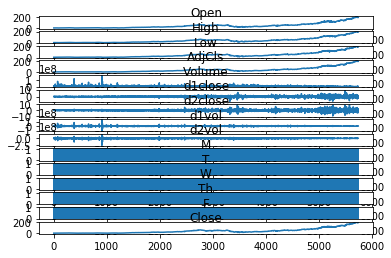

In [6]:
# Plot the features
visualize.plot_features(dataset)


In [7]:
# frame as supervised learning
# this will be for scaling the data to the window scaled_in to scaled_out
reframed=ps.series_to_supervised(dataset, n_in=n_in, n_out=n_out, 
                                   features=features)

starting Series to supverised conversion...


In [8]:
# drop all but the 'target' from the predictor set
# this might be able to take an array for multi-output
reframed=ps.frame_targets(reframed, features, n_out,target=target)

#scaler = MinMaxScaler(feature_range=(-1, 1))
#scaled = scaler.fit_transform(reframed)
# pass the feature in the sequence that we dont want scaled

In [33]:
#reframed=reframed.iloc[:10,:] #test/debug
#dataset=reframed
scaled=ps.scale_sequence(reframed, features, 
                         scaleTarget=True, target=target)

Scaling each sequence...
 Progress....1.09Sequence scaling complete.


In [9]:
scaled=reframed

In [10]:
#getStocks.saveScaled(scaled, n_in, n_out, ticker)
# load scaled 

#scaled=pd.read_csv('../data/astc/astc_29092017_scaled_30_30.csv')


# put in order of time (t-n_in should be on left of df, with t+ on the right)

# split into train, validation, test
train, validation, test = lstm.tscv(scaled, train=0.7, validation=0.25)

In [11]:
# split into input and outputs
# the last n columns are the output variable

train_X, train_y = train[:, :-n_out], train[:, -n_out:]
X_validation, Y_validation = validation[:, :-n_out], validation[:, -n_out:]
test_X, test_y = test[:, :-n_out], test[:, -n_out:]

In [12]:
# ensure the shaping makes sense the way all the variables are arranged
# reshape input to be 3D [samples(observations), timesteps (n_in), features]
train_X = ps.shape(train_X, n_in=n_in, features=features)
X_validation = ps.shape(X_validation, n_in=n_in, features=features)
test_X = ps.shape(test_X, n_in=n_in, features=features)

In [20]:
import imp
imp.reload(lstm)

<module 'lstm' from 'D:\\projects\\4cast\\src\\lstm.py'>

In [18]:
model = lstm.build_model(train_X, 
                         timesteps=n_in, 
                         inlayer=int(train_X.shape[-1]*150),
                         hiddenlayers=[100], 
                         outlayer=n_out)

Compilation Time :  0.01905035972595215
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 30, 2250)          20394000  
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 2250)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               940400    
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 21,335,410
Trainable params: 21,335,410
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit network and save to history
history = model.fit(train_X, train_y, 
                    epochs=200, 
                    batch_size=256, 
                    validation_data=(X_validation, Y_validation), 
                    verbose=2, shuffle=False)

# plot history
visualize.plot_loss(history)

Train on 3987 samples, validate on 1425 samples
Epoch 1/200
10s - loss: 704.2468 - val_loss: 6548.2801
Epoch 2/200
8s - loss: 643.4552 - val_loss: 6358.5613
Epoch 3/200
8s - loss: 597.6697 - val_loss: 6178.0888
Epoch 4/200
8s - loss: 556.9904 - val_loss: 6013.4178
Epoch 5/200
8s - loss: 521.9573 - val_loss: 5860.9496
Epoch 6/200
8s - loss: 490.5837 - val_loss: 5719.3659
Epoch 7/200
8s - loss: 462.8148 - val_loss: 5587.5819
Epoch 8/200
8s - loss: 440.2008 - val_loss: 5465.0761
Epoch 9/200
8s - loss: 419.4978 - val_loss: 5351.2316
Epoch 10/200
8s - loss: 400.8506 - val_loss: 5245.2585
Epoch 11/200
8s - loss: 384.6420 - val_loss: 5146.6334
Epoch 12/200
8s - loss: 370.6516 - val_loss: 5055.1298
Epoch 13/200
8s - loss: 359.5815 - val_loss: 4969.9677
Epoch 14/200
8s - loss: 349.4591 - val_loss: 4891.1322
Epoch 15/200
8s - loss: 339.1114 - val_loss: 4818.2336
Epoch 16/200
8s - loss: 333.5201 - val_loss: 4750.6190
Epoch 17/200
8s - loss: 326.5864 - val_loss: 4688.2949
Epoch 18/200
8s - loss: 3

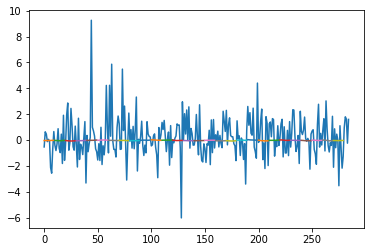

In [16]:
### KEEP THIS WORKING ####
yhat = predicts.predict_sequences_multiple(model, test_X, n_in, n_out)
visualize.plot_results_multiple(yhat, test_y[:,0], n_out, legend=False)
# visualize.plot_single(yhat, test_y, ticker, data_set_category='test')

In [ ]:
###### TODO METHOD####
#import predicts
## copy weights
#old_weights=model.get_weights()
#
#new_model = Sequential()
#new_model.add(LSTM(30, input_shape=(train_X.shape[1], train_X.shape[2]),
#          return_sequences=True, activation='tanh'))
#new_model.add(Dropout(0.5))
#new_model.add(LSTM(10, activation='tanh'))
#new_model.add(Dropout(0.5))
#new_model.add(Dense(1))
#new_model.compile(loss='mae', optimizer='adam')
## fit network
#new_model.set_weights(old_weights)
#predicts.onlineForecast(new_model, test_X, test_y)
## # # ____ # # #